In [1]:
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import time
from scipy import stats
from scipy.stats import zscore
import random
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import scipy.stats
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy
import itertools
from typing import List
import time
from scipy import stats
from scipy.stats import zscore
import random
import sys

In [2]:
df_modeling_scaled=pd.read_csv('df_modeling_scaled.csv')
df_oot=pd.read_csv('df_oot.csv')
var_selected_rfe=pd.read_csv('fs_logreg_ranks.csv')
var_SBS=pd.read_csv('varsFS.csv')
var_SBS2=pd.read_csv('varsFS2.csv')
var_SBS3=pd.read_csv('varsFS_log_roc.csv')
var_SBS4=pd.read_csv('varsFS_random_accuarcy.csv')

In [3]:
final_wrapper_columns=var_SBS3.feature_names[19]
final_wrapper_columns

"('cardnum_zip_total_7', 'cardnum_merchdes_total_7', 'cardnum_state_total_3', 'cardnum_merchdes_total_14', 'cardnum_zip_total_14', 'cardnum_state_total_7', 'cardnum_merch_total_1', 'cardnum_merch_total_30', 'cardnum_merchdes_max_14', 'cardnum_merchdes_total_0', 'cardnum_state_max_7', 'cardnum_merch_max_14', 'Cardnum_total_7', 'merchnum_zip_total_1', 'merchdes_state_total_0', 'merchdes_zip_max_0', 'merchdes_zip_total_0', 'merchdes_zip_max_1', 'Cardnum_total_0', 'cardnum_merchdes_max_0')"

In [4]:
def Convert(string):
    li = list(string.split(","))
    return li
  
# Driver code    
str1 = final_wrapper_columns[1:-1]
print(Convert(str1))
x=Convert(str1)

["'cardnum_zip_total_7'", " 'cardnum_merchdes_total_7'", " 'cardnum_state_total_3'", " 'cardnum_merchdes_total_14'", " 'cardnum_zip_total_14'", " 'cardnum_state_total_7'", " 'cardnum_merch_total_1'", " 'cardnum_merch_total_30'", " 'cardnum_merchdes_max_14'", " 'cardnum_merchdes_total_0'", " 'cardnum_state_max_7'", " 'cardnum_merch_max_14'", " 'Cardnum_total_7'", " 'merchnum_zip_total_1'", " 'merchdes_state_total_0'", " 'merchdes_zip_max_0'", " 'merchdes_zip_total_0'", " 'merchdes_zip_max_1'", " 'Cardnum_total_0'", " 'cardnum_merchdes_max_0'"]


In [5]:
final_wrapper_columns=[]
for i in x:
    final_wrapper_columns.append(eval(i))
final_wrapper_columns=np.array(final_wrapper_columns)
final_wrapper_columns


array(['cardnum_zip_total_7', 'cardnum_merchdes_total_7',
       'cardnum_state_total_3', 'cardnum_merchdes_total_14',
       'cardnum_zip_total_14', 'cardnum_state_total_7',
       'cardnum_merch_total_1', 'cardnum_merch_total_30',
       'cardnum_merchdes_max_14', 'cardnum_merchdes_total_0',
       'cardnum_state_max_7', 'cardnum_merch_max_14', 'Cardnum_total_7',
       'merchnum_zip_total_1', 'merchdes_state_total_0',
       'merchdes_zip_max_0', 'merchdes_zip_total_0', 'merchdes_zip_max_1',
       'Cardnum_total_0', 'cardnum_merchdes_max_0'], dtype='<U25')

In [6]:
X_models = df_modeling_scaled[final_wrapper_columns] # training set
Y_labels = df_modeling_scaled['Fraud'] #labels
X_oot_orig = df_oot[final_wrapper_columns] #OOT set
Y_oot_orig = df_oot['Fraud']

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

In [45]:
# Random Forest 1
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 50, max_depth=5)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7755102040816326 0.7392857142857143 0.5586592178770949
1 0.7701342281879194 0.75 0.553072625698324
2 0.7585644371941273 0.7568627450980392 0.5418994413407822
3 0.7611940298507462 0.7547169811320755 0.5698324022346368
4 0.755632582322357 0.7422680412371134 0.5363128491620112
5 0.7725752508361204 0.6888888888888889 0.5418994413407822
6 0.7736757624398074 0.7183673469387755 0.4972067039106145
7 0.7648953301127214 0.7813765182186235 0.547486033519553
8 0.764612954186414 0.8212765957446808 0.547486033519553
9 0.762214983713355 0.7519685039370079 0.5642458100558659


trn    0.765901
tst    0.750501
oot    0.545810
dtype: float64

In [46]:
# Random Forest 2
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 60, max_depth=5)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7393526405451448 0.7758007117437722 0.5754189944134078
1 0.7521222410865874 0.7347670250896058 0.547486033519553
2 0.7548387096774194 0.7298387096774194 0.5810055865921788
3 0.802675585284281 0.7444444444444445 0.5418994413407822
4 0.7698675496688742 0.7537878787878788 0.5363128491620112
5 0.7768456375838926 0.7279411764705882 0.553072625698324
6 0.7558528428093646 0.7111111111111111 0.4860335195530726
7 0.7579113924050633 0.7669491525423728 0.5418994413407822
8 0.7248764415156508 0.7318007662835249 0.48044692737430167
9 0.7777777777777778 0.7279151943462897 0.5586592178770949


trn    0.761212
tst    0.740436
oot    0.540223
dtype: float64

In [47]:
# Random Forest 3
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 70, max_depth=5)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.768 0.7613168724279835 0.5586592178770949
1 0.7479806138933764 0.7911646586345381 0.5698324022346368
2 0.7651757188498403 0.7603305785123967 0.553072625698324
3 0.7804878048780488 0.7193675889328063 0.5251396648044693
4 0.782608695652174 0.7651821862348178 0.5083798882681564
5 0.7672552166934189 0.7428571428571429 0.5363128491620112
6 0.8006814310051107 0.6868327402135231 0.5754189944134078
7 0.7677419354838709 0.7096774193548387 0.553072625698324
8 0.7772435897435898 0.7090163934426229 0.5586592178770949
9 0.7751277683134583 0.708185053380783 0.5810055865921788


trn    0.773230
tst    0.735393
oot    0.551955
dtype: float64

In [48]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 80, max_depth=5)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7618243243243243 0.7644927536231884 0.5418994413407822
1 0.7738693467336684 0.7453874538745388 0.5586592178770949
2 0.7761437908496732 0.73828125 0.5418994413407822
3 0.7885532591414944 0.7364016736401674 0.5698324022346368
4 0.7765273311897106 0.7520325203252033 0.5418994413407822
5 0.7732656514382402 0.7292418772563177 0.5363128491620112
6 0.7655986509274874 0.7490909090909091 0.5586592178770949
7 0.7626016260162601 0.7747035573122529 0.553072625698324
8 0.7767441860465116 0.7309417040358744 0.5586592178770949
9 0.790893760539629 0.7418181818181818 0.5810055865921788


trn    0.774602
tst    0.746239
oot    0.554190
dtype: float64

In [49]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 90, max_depth=5)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7989949748743719 0.6937269372693727 0.5586592178770949
1 0.7835570469798657 0.7573529411764706 0.5754189944134078
2 0.7781402936378466 0.7176470588235294 0.553072625698324
3 0.7751677852348994 0.75 0.553072625698324
4 0.7731788079470199 0.7462121212121212 0.4972067039106145
5 0.7804459691252144 0.743859649122807 0.5418994413407822
6 0.7662771285475793 0.7769516728624535 0.553072625698324
7 0.7679180887372014 0.7553191489361702 0.5586592178770949
8 0.7752442996742671 0.7362204724409449 0.5139664804469274
9 0.7619047619047619 0.749034749034749 0.5251396648044693


trn    0.776083
tst    0.742632
oot    0.543017
dtype: float64

In [50]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 100, max_depth=5)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7592295345104334 0.7591836734693878 0.5586592178770949
1 0.777027027027027 0.7717391304347826 0.5418994413407822
2 0.763458401305057 0.7607843137254902 0.5418994413407822
3 0.75 0.7380952380952381 0.5027932960893855
4 0.7735849056603774 0.7887931034482759 0.5921787709497207
5 0.7664576802507836 0.7695652173913043 0.553072625698324
6 0.7574257425742574 0.7977099236641222 0.5642458100558659
7 0.7623762376237624 0.7633587786259542 0.5251396648044693
8 0.7887788778877888 0.7290076335877863 0.5418994413407822
9 0.7646076794657763 0.7509293680297398 0.5586592178770949


trn    0.766295
tst    0.762917
oot    0.548045
dtype: float64

In [51]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 50, max_depth=6)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7929292929292929 0.718978102189781 0.547486033519553
1 0.7775974025974026 0.7817460317460317 0.5586592178770949
2 0.7892976588628763 0.774074074074074 0.5810055865921788
3 0.7732656514382402 0.7545126353790613 0.553072625698324
4 0.7866449511400652 0.7755905511811023 0.5810055865921788
5 0.7728813559322034 0.737410071942446 0.4972067039106145
6 0.7808896210873146 0.7777777777777778 0.5977653631284916
7 0.785 0.7686567164179104 0.5586592178770949
8 0.7947019867549668 0.7234848484848485 0.5642458100558659
9 0.7881219903691814 0.7346938775510204 0.5754189944134078


trn    0.784133
tst    0.754692
oot    0.561453
dtype: float64

In [52]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 60, max_depth=6)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7899159663865546 0.7472527472527473 0.5754189944134078
1 0.7783333333333333 0.75 0.5754189944134078
2 0.8107667210440457 0.788235294117647 0.5698324022346368
3 0.7873376623376623 0.7619047619047619 0.5642458100558659
4 0.8013245033112583 0.7727272727272727 0.5810055865921788
5 0.7996661101836394 0.7397769516728625 0.547486033519553
6 0.7909238249594813 0.7529880478087649 0.5698324022346368
7 0.7883683360258481 0.7469879518072289 0.5642458100558659
8 0.7829861111111112 0.7465753424657534 0.5642458100558659
9 0.8070469798657718 0.7352941176470589 0.5810055865921788


trn    0.793667
tst    0.754174
oot    0.569274
dtype: float64

In [53]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 70, max_depth=6)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7868852459016393 0.7751937984496124 0.5921787709497207
1 0.8079470198675497 0.7424242424242424 0.5810055865921788
2 0.7970297029702971 0.7557251908396947 0.6145251396648045
3 0.8013816925734024 0.740484429065744 0.5642458100558659
4 0.7915966386554621 0.7509157509157509 0.5865921787709497
5 0.799660441426146 0.7383512544802867 0.5642458100558659
6 0.7855973813420621 0.7821011673151751 0.5363128491620112
7 0.7829581993569131 0.7520325203252033 0.5698324022346368
8 0.7905511811023622 0.7682403433476395 0.6089385474860335
9 0.773015873015873 0.7899159663865546 0.5642458100558659


trn    0.791662
tst    0.759538
oot    0.578212
dtype: float64

In [54]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 80, max_depth=6)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7921440261865794 0.7509727626459144 0.5754189944134078
1 0.8169257340241797 0.7785467128027682 0.5363128491620112
2 0.7914614121510674 0.7451737451737451 0.5586592178770949
3 0.7896440129449838 0.748 0.5363128491620112
4 0.799347471451876 0.7411764705882353 0.5754189944134078
5 0.7815126050420168 0.7582417582417582 0.5586592178770949
6 0.7980132450331126 0.75 0.5642458100558659
7 0.7946577629382304 0.7434944237918215 0.6033519553072626
8 0.7958199356913184 0.7560975609756098 0.5977653631284916
9 0.8057921635434412 0.7580071174377224 0.5810055865921788


trn    0.796532
tst    0.752971
oot    0.568715
dtype: float64

In [55]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 90, max_depth=6)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7734899328859061 0.7683823529411765 0.553072625698324
1 0.797716150081566 0.7490196078431373 0.5586592178770949
2 0.8054607508532423 0.7198581560283688 0.5698324022346368
3 0.797716150081566 0.7843137254901961 0.5921787709497207
4 0.8023648648648649 0.7210144927536232 0.6145251396648045
5 0.8052805280528053 0.767175572519084 0.5977653631284916
6 0.7811993517017828 0.7290836653386454 0.553072625698324
7 0.7844827586206896 0.7465277777777778 0.5642458100558659
8 0.7953488372093023 0.7443946188340808 0.5642458100558659
9 0.7926634768740032 0.7842323651452282 0.5865921787709497


trn    0.793572
tst    0.751400
oot    0.575419
dtype: float64

In [56]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 100, max_depth=6)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.7774086378737541 0.7969924812030075 0.5921787709497207
1 0.7873376623376623 0.746031746031746 0.5754189944134078
2 0.7952 0.7654320987654321 0.553072625698324
3 0.785 0.8134328358208955 0.5977653631284916
4 0.7783251231527094 0.7953667953667953 0.5754189944134078
5 0.7845117845117845 0.791970802919708 0.5810055865921788
6 0.8016806722689076 0.73992673992674 0.5865921787709497
7 0.7841483979763912 0.8036363636363636 0.5698324022346368
8 0.7761194029850746 0.8188679245283019 0.6033519553072626
9 0.8032 0.7901234567901234 0.5642458100558659


trn    0.787293
tst    0.786178
oot    0.579888
dtype: float64

In [57]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 50, max_depth=10)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.8774193548387097 0.8185483870967742 0.5754189944134078
1 0.8675078864353313 0.7905982905982906 0.6089385474860335
2 0.8621848739495799 0.7875457875457875 0.5810055865921788
3 0.8926829268292683 0.8063241106719368 0.5977653631284916
4 0.8955223880597015 0.8188679245283019 0.6145251396648045
5 0.8896210873146623 0.8122605363984674 0.6145251396648045
6 0.8813838550247117 0.8160919540229885 0.6089385474860335
7 0.865 0.8246268656716418 0.6089385474860335
8 0.8851351351351351 0.8043478260869565 0.5865921787709497
9 0.9138211382113821 0.7747035573122529 0.6089385474860335


trn    0.883028
tst    0.805392
oot    0.600559
dtype: float64

In [58]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 60, max_depth=10)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.8921568627450981 0.80078125 0.6312849162011173
1 0.8856209150326797 0.8125 0.5977653631284916
2 0.8937908496732027 0.83984375 0.6145251396648045
3 0.8726114649681529 0.8041666666666667 0.6089385474860335
4 0.880718954248366 0.79296875 0.6089385474860335
5 0.8726968174204355 0.8265682656826568 0.6033519553072626
6 0.8766666666666667 0.7947761194029851 0.5810055865921788
7 0.8972602739726028 0.7887323943661971 0.6145251396648045
8 0.8885350318471338 0.8375 0.6145251396648045
9 0.9098228663446055 0.7854251012145749 0.5810055865921788


trn    0.886988
tst    0.808326
oot    0.605587
dtype: float64

In [59]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 70, max_depth=10)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.8876582278481012 0.8389830508474576 0.6145251396648045
1 0.8823529411764706 0.80859375 0.5977653631284916
2 0.8958990536277602 0.782051282051282 0.5810055865921788
3 0.8756302521008403 0.8351648351648352 0.5921787709497207
4 0.8869143780290791 0.8433734939759037 0.6033519553072626
5 0.8918918918918919 0.7753623188405797 0.6033519553072626
6 0.8910891089108911 0.816793893129771 0.6033519553072626
7 0.8832236842105263 0.8115384615384615 0.6145251396648045
8 0.877104377104377 0.8576642335766423 0.6033519553072626
9 0.8658346333853354 0.8237885462555066 0.5642458100558659


trn    0.883760
tst    0.819331
oot    0.597765
dtype: float64

In [60]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 80, max_depth=10)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.8762214983713354 0.7834645669291339 0.5921787709497207
1 0.8731707317073171 0.8142292490118577 0.6033519553072626
2 0.8915094339622641 0.7887931034482759 0.5865921787709497
3 0.8797250859106529 0.7937062937062938 0.6089385474860335
4 0.880718954248366 0.8046875 0.5977653631284916
5 0.8687196110210696 0.8247011952191236 0.6089385474860335
6 0.8721461187214612 0.7867298578199052 0.6145251396648045
7 0.8862068965517241 0.7777777777777778 0.5977653631284916
8 0.883248730964467 0.851985559566787 0.5977653631284916
9 0.8729903536977492 0.8455284552845529 0.5698324022346368


trn    0.878466
tst    0.807160
oot    0.597765
dtype: float64

In [16]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,y_trn,y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 90, max_depth=10)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=y_trn.values
    Y_tst_array=y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.8631921824104235 0.8385826771653543 0.6256983240223464


KeyboardInterrupt: 

In [62]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 100, max_depth=10)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.8852459016393442 0.813953488372093 0.6089385474860335
1 0.8817733990147784 0.833976833976834 0.6145251396648045
2 0.8907014681892332 0.7803921568627451 0.5921787709497207
3 0.8868552412645591 0.8202247191011236 0.6089385474860335
4 0.8977072310405644 0.8073089700996677 0.6312849162011173
5 0.8777219430485762 0.8154981549815498 0.6089385474860335
6 0.8675496688741722 0.8409090909090909 0.5921787709497207
7 0.8816 0.7983539094650206 0.5977653631284916
8 0.8821705426356589 0.8609865470852018 0.6145251396648045
9 0.910828025477707 0.7958333333333333 0.5921787709497207


trn    0.886215
tst    0.816744
oot    0.606145
dtype: float64

In [63]:
# Random Forest 4
FDR3 = pd.DataFrame(columns=['trn', 'tst', 'oot'])
for niter in range(10):
    X_trn,X_tst,Y_trn,Y_tst=train_test_split(X_models,Y_labels,train_size=0.7,test_size=0.3)
    
    random_forest_1 = RandomForestClassifier(max_features = 7,
                                            n_estimators = 50, max_depth=15)
    X_trn_array=X_trn.values
    X_tst_array=X_tst.values
    X_oot_array=X_oot_orig.values
    Y_trn_array=Y_trn.values
    Y_tst_array=Y_tst.values
    Y_oot_array=Y_oot_orig.values
    
    X_oot=X_oot_orig.copy()
    X_trn_eval=X_trn.copy()
    X_tst_eval=X_tst.copy()
    X_oot_eval=X_oot.copy()
    
    
    random_forest_1.fit(X_trn,Y_trn.values.ravel())
    predictions=random_forest_1.predict_proba(X_trn)[:,1]
    
    X_trn_eval['predicted']=predictions
    X_trn_eval['Fraud']=Y_trn
    topRows=int(round(X_trn_eval.shape[0]*0.03))
    temp=X_trn_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'trn']=sum(needed)/sum(X_trn_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_tst)[:,1]
    
    X_tst_eval['predicted']=predictions
    X_tst_eval['Fraud']=Y_tst
    topRows=int(round(X_tst_eval.shape[0]*0.03))
    temp=X_tst_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'tst']=sum(needed)/sum(X_tst_eval.loc[:,'Fraud'])
    
    predictions=random_forest_1.predict_proba(X_oot)[:,1]
    
    X_oot_eval['predicted']=predictions
    X_oot_eval['Fraud']=Y_oot_orig
    topRows=int(round(X_oot_eval.shape[0]*0.03))
    temp=X_oot_eval.sort_values('predicted',ascending=False).head(topRows)
    needed=temp.loc[:,'Fraud']
    FDR3.loc[niter,'oot']=sum(needed)/sum(X_oot_eval.loc[:,'Fraud'])
    print(niter, FDR3.loc[niter,'trn'],FDR3.loc[niter,'tst'],FDR3.loc[niter,'oot'])
FDR3.mean()

0 0.9917355371900827 0.8403041825095057 0.6201117318435754
1 0.9816666666666667 0.8619402985074627 0.5698324022346368
2 0.96875 0.85 0.6256983240223464
3 0.9864864864864865 0.8115942028985508 0.5977653631284916
4 0.9789644012944984 0.816 0.5921787709497207
5 0.9884868421052632 0.8576923076923076 0.6312849162011173
6 0.9919224555735057 0.8674698795180723 0.6201117318435754
7 0.9713831478537361 0.8242677824267782 0.6536312849162011
8 0.9675850891410048 0.8286852589641435 0.6089385474860335
9 0.9837925445705025 0.8406374501992032 0.6256983240223464


trn    0.981077
tst    0.839859
oot    0.614525
dtype: float64

In [91]:
def output_table(y_res_valid,Y_valid):
# returs the output tables
# y_res_valis is y_pred
# Y_valid is y_true
# returns:
# cumulative dataset, Bin Statistics
    no_of_bads =Y_valid.sum()
    no_of_records = len(Y_valid)
    no_of_goods = no_of_records - no_of_bads
    print('no_of_records',no_of_records)
    print('No of bads',no_of_bads)
    print('no_of_goods',no_of_goods)

    fin_tabl_df = pd.DataFrame({'score':y_res_valid,'label': Y_valid}).sort_values(by='score',ascending=False)
    df_pres_cum = pd.DataFrame(columns=['Total # Records','# Goods','# Bads'])
    for i_tbl_df in range(1,21): #21 is the final
    #     print(i_tbl_df)
        top3_res2 = fin_tabl_df.head(round(Y_valid.shape[0]*(i_tbl_df/100)))
        top3_res2#['label'].sum()/sum(Y_valid)
    #     print('No of records:',top3_res2.shape[0])
        df_pres_cum.loc[i_tbl_df-1,'Total # Records'] = top3_res2.shape[0]
    #     print('No of bads:',top3_res2['label'].sum())
        df_pres_cum.loc[i_tbl_df-1,'# Bads'] = top3_res2['label'].sum()
    #     print('No of goods:',top3_res2.shape[0]- top3_res2['label'].sum())
        df_pres_cum.loc[i_tbl_df-1,'# Goods'] = top3_res2.shape[0]- top3_res2['label'].sum()

    df_pres = df_pres_cum.diff()
    df_pres.loc[0] = df_pres_cum.loc[0]
    df_pres = df_pres.rename(columns={"Total # Records": "# Records"})
    df_pres['% Goods'] = 100*(df_pres['# Goods']/df_pres['# Records'])
    df_pres['% Bads'] = 100*(df_pres['# Bads']/df_pres['# Records'])
    print('Bin statistics')
    df_pres.to_csv('Test_Bin_stats.csv')
    display(df_pres)

    df_pres_cum['% Goods'] = 100*(df_pres_cum['# Goods']/no_of_goods)
    df_pres_cum['% Bads'] = 100*(df_pres_cum['# Bads']/no_of_bads)
    df_pres_cum['KS'] = df_pres_cum['% Bads'] - df_pres_cum['% Goods']
    df_pres_cum['FPR'] = df_pres_cum['# Goods']/df_pres_cum['# Bads']
    df_pres_cum = df_pres_cum.rename(columns={"# Goods": "Cumulative Goods",'# Bads':'Cumulative Bads','% Bads':'% Bads (FDR)'})
    print('Cumulative results')
    df_pres_cum.to_csv('Test_Cum_stats.csv') 
    display(df_pres_cum)
    return df_pres_cum, df_pres

In [85]:
random_forest_final=RandomForestClassifier(max_features = 7, n_estimators=90, max_depth=10)
random_forest_final.fit(X_models,Y_labels)

RandomForestClassifier(max_depth=10, max_features=7, n_estimators=90)

In [86]:
y_trn['Fraud Proba'] =  random_forest_final.predict_proba(X_trn)[:,1].tolist()
y_tst['Fraud Proba'] =  random_forest_final.predict_proba(X_tst)[:,1].tolist()
Y_oot_orig['Fraud Proba'] =  random_forest_final.predict_proba(X_oot)[:,1].tolist()

In [93]:
output_table(y_trn['Fraud Proba'],y_trn.iloc[:-1])

no_of_records 56442
No of bads 616
no_of_goods 55826
Bin statistics


,# Records,# Goods,# Bads,% Goods,% Bads
0,564,70,494,12.4113,87.5887
1,565,532,33,94.1593,5.84071
2,564,552,12,97.8723,2.12766
3,565,559,6,98.9381,1.06195
4,564,555,9,98.4043,1.59574
5,565,557,8,98.5841,1.41593
6,564,558,6,98.9362,1.06383
7,564,562,2,99.6454,0.35461
8,565,563,2,99.646,0.353982
9,564,555,9,98.4043,1.59574


Cumulative results


,Total # Records,Cumulative Goods,Cumulative Bads,% Goods,% Bads (FDR),KS,FPR
0,564,70,494,0.12539,80.1948,80.0694,0.1417
1,1129,602,527,1.07835,85.5519,84.4736,1.14231
2,1693,1154,539,2.06714,87.5,85.4329,2.141
3,2258,1713,545,3.06846,88.474,85.4056,3.14312
4,2822,2268,554,4.06262,89.9351,85.8724,4.09386
5,3387,2825,562,5.06037,91.2338,86.1734,5.02669
6,3951,3383,568,6.0599,92.2078,86.1479,5.95599
7,4515,3945,570,7.0666,92.5325,85.4659,6.92105
8,5080,4508,572,8.07509,92.8571,84.7821,7.88112
9,5644,5063,581,9.06925,94.3182,85.2489,8.71429


(   Total # Records Cumulative Goods Cumulative Bads  % Goods % Bads (FDR)       KS      FPR
 0              564               70             494  0.12539      80.1948  80.0694   0.1417
 1             1129              602             527  1.07835      85.5519  84.4736  1.14231
 2             1693             1154             539  2.06714         87.5  85.4329    2.141
 3             2258             1713             545  3.06846       88.474  85.4056  3.14312
 4             2822             2268             554  4.06262      89.9351  85.8724  4.09386
 5             3387             2825             562  5.06037      91.2338  86.1734  5.02669
 6             3951             3383             568   6.0599      92.2078  86.1479  5.95599
 7             4515             3945             570   7.0666      92.5325  85.4659  6.92105
 8             5080             4508             572  8.07509      92.8571  84.7821  7.88112
 9             5644             5063             581  9.06925      94.

In [94]:
output_table(y_tst['Fraud Proba'],y_tst.iloc[:-1])

no_of_records 24190
No of bads 252
no_of_goods 23938
Bin statistics


,# Records,# Goods,# Bads,% Goods,% Bads
0,242,44,198,18.1818,81.8182
1,242,228,14,94.2149,5.78512
2,242,239,3,98.7603,1.23967
3,242,234,8,96.6942,3.30579
4,242,237,5,97.9339,2.06612
5,241,237,4,98.3402,1.65975
6,242,240,2,99.1736,0.826446
7,242,242,0,100,0
8,242,240,2,99.1736,0.826446
9,242,238,4,98.3471,1.65289


Cumulative results


,Total # Records,Cumulative Goods,Cumulative Bads,% Goods,% Bads (FDR),KS,FPR
0,242,44,198,0.183808,78.5714,78.3876,0.222222
1,484,272,212,1.13627,84.127,82.9907,1.28302
2,726,511,215,2.13468,85.3175,83.1828,2.37674
3,968,745,223,3.11221,88.4921,85.3799,3.34081
4,1210,982,228,4.10226,90.4762,86.3739,4.30702
5,1451,1219,232,5.09232,92.0635,86.9712,5.25431
6,1693,1459,234,6.09491,92.8571,86.7622,6.23504
7,1935,1701,234,7.10586,92.8571,85.7513,7.26923
8,2177,1941,236,8.10845,93.6508,85.5423,8.22458
9,2419,2179,240,9.10268,95.2381,86.1354,9.07917


(   Total # Records Cumulative Goods Cumulative Bads   % Goods % Bads (FDR)       KS       FPR
 0              242               44             198  0.183808      78.5714  78.3876  0.222222
 1              484              272             212   1.13627       84.127  82.9907   1.28302
 2              726              511             215   2.13468      85.3175  83.1828   2.37674
 3              968              745             223   3.11221      88.4921  85.3799   3.34081
 4             1210              982             228   4.10226      90.4762  86.3739   4.30702
 5             1451             1219             232   5.09232      92.0635  86.9712   5.25431
 6             1693             1459             234   6.09491      92.8571  86.7622   6.23504
 7             1935             1701             234   7.10586      92.8571  85.7513   7.26923
 8             2177             1941             236   8.10845      93.6508  85.5423   8.22458
 9             2419             2179             2

In [92]:
output_table(Y_oot_orig['Fraud Proba'],Y_oot_orig.iloc[:-1])

no_of_records 12427
No of bads 179
no_of_goods 12248
Bin statistics


,# Records,# Goods,# Bads,% Goods,% Bads
0,124,49,75,39.5161,60.4839
1,125,99,26,79.2,20.8
2,124,113,11,91.129,8.87097
3,124,119,5,95.9677,4.03226
4,124,121,3,97.5806,2.41935
5,125,124,1,99.2,0.8
6,124,120,4,96.7742,3.22581
7,124,123,1,99.1935,0.806452
8,124,122,2,98.3871,1.6129
9,125,117,8,93.6,6.4


Cumulative results


,Total # Records,Cumulative Goods,Cumulative Bads,% Goods,% Bads (FDR),KS,FPR
0,124,49,75,0.400065,41.8994,41.4994,0.653333
1,249,148,101,1.20836,56.4246,55.2162,1.46535
2,373,261,112,2.13096,62.5698,60.4389,2.33036
3,497,380,117,3.10255,65.3631,62.2606,3.24786
4,621,501,120,4.09046,67.0391,62.9486,4.175
5,746,625,121,5.10287,67.5978,62.4949,5.16529
6,870,745,125,6.08263,69.8324,63.7498,5.96
7,994,868,126,7.08687,70.3911,63.3042,6.88889
8,1118,990,128,8.08295,71.5084,63.4254,7.73438
9,1243,1107,136,9.03821,75.9777,66.9394,8.13971


(   Total # Records Cumulative Goods Cumulative Bads   % Goods % Bads (FDR)       KS       FPR
 0              124               49              75  0.400065      41.8994  41.4994  0.653333
 1              249              148             101   1.20836      56.4246  55.2162   1.46535
 2              373              261             112   2.13096      62.5698  60.4389   2.33036
 3              497              380             117   3.10255      65.3631  62.2606   3.24786
 4              621              501             120   4.09046      67.0391  62.9486     4.175
 5              746              625             121   5.10287      67.5978  62.4949   5.16529
 6              870              745             125   6.08263      69.8324  63.7498      5.96
 7              994              868             126   7.08687      70.3911  63.3042   6.88889
 8             1118              990             128   8.08295      71.5084  63.4254   7.73438
 9             1243             1107             1

In [95]:
# Function to calculate savings
# Assuming $2000 gain for every True Positive
def fraud_savings(model,X_data, Y_data,i):
    Y_data = pd.DataFrame(Y_data)
    Y_data['Fraud Proba'] = model.predict_proba(X_data)[:,1].tolist()
    Y_data = Y_data.sort_values(by='Fraud Proba',ascending=False)
    # total_bads = Y_data['Fraud'][Y_data['Fraud']==1].count()
    top_rows = int(len(X_data)*i*.01)
    sum_bads = Y_data['Fraud'].head(top_rows)[Y_data['Fraud']==1].count()
    # loss = Y_data['Fraud'].head(top_rows)[Y_data['Fraud']==0].count()
    fraud_savings = sum_bads*2000    
    return fraud_savings

In [96]:
# Function to calculate losses
# Assuming $50 loss for every False Positive
def fraud_losses(model,X_data, Y_data,i):
    Y_data = pd.DataFrame(Y_data)
    Y_data['Fraud Proba'] = model.predict_proba(X_data)[:,1].tolist()
    Y_data = Y_data.sort_values(by='Fraud Proba',ascending=False)
    # total_bads = Y_data['Fraud'][Y_data['Fraud']==1].count()
    top_rows = int(len(X_data)*i*.01)
    #sum_bads = Y_data['Fraud'].head(top_rows)[Y_data['Fraud']==1].count()
    loss = Y_data['Fraud'].head(top_rows)[Y_data['Fraud']==0].count()
    fraud_losses = loss*50   
    return fraud_losses

In [97]:
# Calculating savings for FDR till 50%
savings = {}
for j in range(0,51):
  savings[j] = fraud_savings(random_forest_final,X_oot_orig,Y_oot_orig.iloc[:-1],j)

In [98]:
# Calculating losses for FDR till 50%
losses = {}
for j in range(0,51):
  losses[j] = fraud_losses(random_forest_final,X_oot_orig,Y_oot_orig.iloc[:-1],j)

In [46]:
import seaborn as sns

In [99]:
# Calculating overall savings by subtracting losses from gains
overall_savings = {key: savings[key] - losses[key] for key in savings}

In [100]:
overall_savings

{0: 0,
 1: 147550,
 2: 194650,
 3: 211000,
 4: 215000,
 5: 214950,
 6: 210800,
 7: 212800,
 8: 208600,
 9: 206500,
 10: 216700,
 11: 214600,
 12: 210400,
 13: 208300,
 14: 202100,
 15: 195850,
 16: 195800,
 17: 189600,
 18: 187500,
 19: 189450,
 20: 185300,
 21: 179100,
 22: 172900,
 23: 168700,
 24: 164550,
 25: 164500,
 26: 158250,
 27: 154100,
 28: 147900,
 29: 143750,
 30: 137500,
 31: 135400,
 32: 129200,
 33: 123000,
 34: 116750,
 35: 114650,
 36: 110500,
 37: 106350,
 38: 100100,
 39: 95950,
 40: 89750,
 41: 83500,
 42: 77300,
 43: 73150,
 44: 75150,
 45: 70950,
 46: 66800,
 47: 60600,
 48: 54400,
 49: 50200,
 50: 44000}

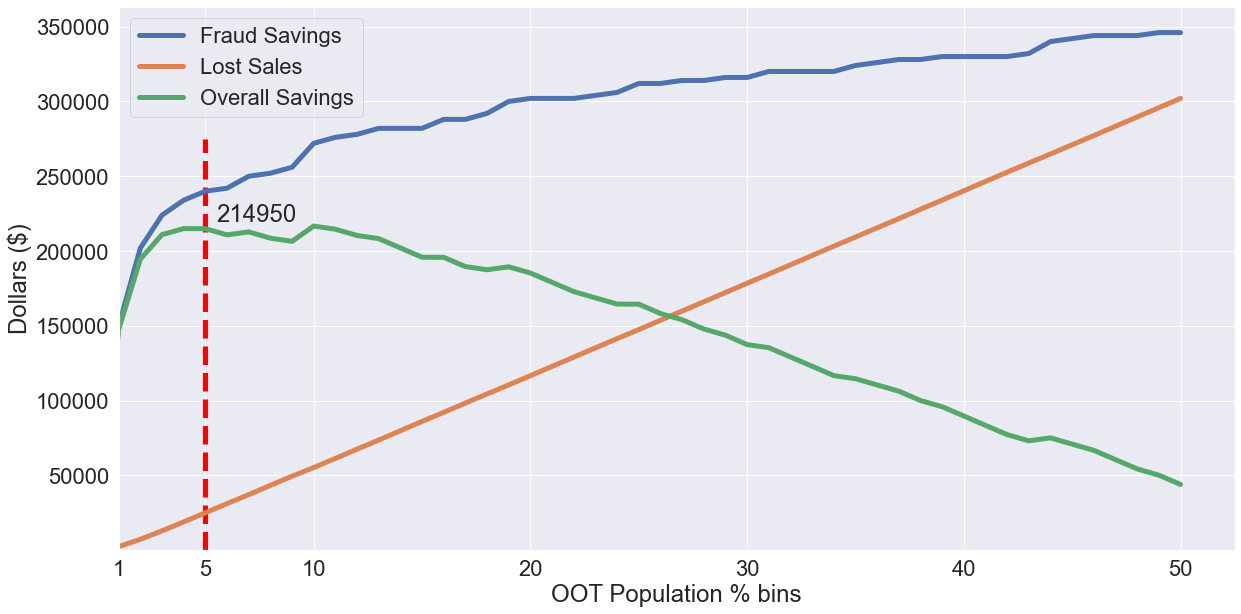

In [102]:
import matplotlib.pylab as plt

sns.set(font_scale=2)
lists = sorted(savings.items()) # sorted by key, return a list of tuples
# loss = sorted(losses.items())
x, y = zip(*lists) # unpack a list of pairs into two tuples
x,z = zip(*losses.items())
x,b = zip(*overall_savings.items())
axes = plt.axes()
plt.plot(x, y, label='Fraud Savings', linewidth = 5)
plt.plot(x,z, label = 'Lost Sales', linewidth = 5)
plt.plot(x,b, label = 'Overall Savings', linewidth = 5)
plt.ylim(ymin=1)
plt.xlim(xmin=1)
plt.xlabel("OOT Population % bins")
plt.ylabel("Dollars ($)")
plt.vlines(x=5, ymin=0, ymax=275000, color='red', zorder=2, linestyles='dashed', linewidth = 5)
axes.set_xticks([1,5,10,20,30,40,50])
plt.annotate('214950',(5.5,220000))
plt.legend()
plt.rcParams["figure.figsize"] = (20,10)
plt.show()